# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import numpy
import os
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from py4cats import *


Py4CAtS --- Python for Computational ATmospheric Spectroscopy

A collection of Python scripts for (molecular) line-by-line absorption
(cross sections, optical depths, ...) and atmospheric radiative transfer

https://doi.org/10.3390/atmos10050262    --->   Atmosphere 10(5), 262, 2019
https://atmos.eoc.dlr.de/tools/Py4CAtS/



In [2]:
# Setup directory
base_dir = r'C:\Users\chris\Dropbox\SCU\Scripts\py4cats'

os.chdir(base_dir)

 Atmos1d: got p & T (computed air density from p/kT)   and 8 molecules on 50 levels
 WARNING --- atmTruncate:  zToA very small, assuming kilometer units
 atmRegrid with default numpy.interp linear interpolation
 WARNING --- atmos1D.atmRegrid:  all altitudes<500, assuming km, converting to cm
 WARNING --- atmos1D.atmRegrid:  new altitude grid exceeding old grid, interpolation might fail to extrapolate
                              0.0 <= zOld <= 5000000.0
                              0.0 <= zGrid <= 5009000.0
 interpolating log(p)
 interpolating log(air)


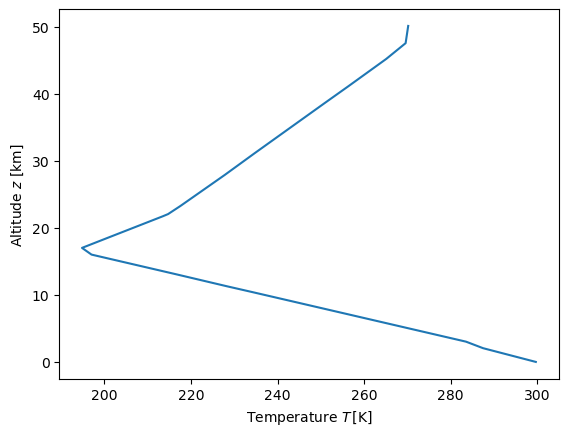

In [3]:
#Read in atmosphere and regrid
hamo = atmRead(r'data\atmos\50\tropical.xy', zToA=50)  #specify the top of the atmosphere
finegrid = np.arange(0, 50.1, 0.01)
hamo_fine = atmRegrid(hamo,finegrid)
atmPlot(hamo_fine)

In [8]:
#Read optical depth file
dodList_O2_full = odRead('mixedgrid_all.dat.dat')  ## Reads in saved optical depth file

ValueError: aeiou.read_first_line failed, file "mixedgrid_all.dat.dat" does not exist

In [ ]:
## Raidance calculate variables
obsAngle=180.0
tSurface=hamo_fine['T'][0] #surface temp, set as water temperature? or air temp?
rSurface=0.04  # surface reflectivity 0.04 is okay for seawater?
zSurface=0.0  # Ground surface alt
sunAngle=82.9339 # look this up per fligh segment
space='data/solar_flux/kurudz_full.dat' #Solar radiance spectrum file
omega=0.0  #single scattering albedo # Setting this above 0 means calculation cannot wrk as is
mode=None 

In [5]:
#Loop through the atmospheric levels
# Iterate through different values of atmlevel
max_alt = 500 # not sure how to extract this from the atmo file right now
atmlevel = 1
results = []
for atmlevel in range(1, 150):
    radBruce = dod2ri(dodList_O2_full[:atmlevel], obsAngle, tSurface, rSurface, zSurface, sunAngle, space, omega)
    # Do something with radBruce, e.g., print it or store it in a list
    radBruce_G = radBruce.convolve(20.,'G')  #convolves the radiance with gaussian of 20 cm-1 HWHM
    x_values = np.linspace(radBruce_G.x.lower, radBruce_G.x.upper, len(radBruce_G))
    df = pd.DataFrame({'cm-1': x_values, 'ergs': radBruce_G})
    df['nm'] = 1e7 / df['cm-1']
    df['W'] = 1e4*df['ergs'] # erg -> joule 1e-7 cm->nm 1e7, cm2->m2 1e4
    band_avR = df[(df['nm'] >= 759) & (df['nm'] <= 766)]['W'].mean()
    bkg_avR = df[(df['nm'] >= 745) & (df['nm'] <= 758)]['W'].mean()
    ratio =band_avR/bkg_avR
    print(f"atmlevel: {atmlevel}, ratio: {ratio}")
    results.append((atmlevel,ratio))


NameError: name 'dodList_O2_full' is not defined

In [64]:
max_alt = 500 # not sure how to extract this from the atmo file right now
results = []

# List to store results dictionaries
results_list = []

# Loop through the atmospheric levels
for atmlevel in range(1, 50):
    ratio_dict = {'atmlevel': atmlevel}
    
    # Loop through sun angles from 0 to 180 in steps of 5 degrees
    for sunAngle in range(40, 120, 15):
        radBruce = dod2ri(dodList_O2_full[:atmlevel], obsAngle, tSurface, rSurface, zSurface, sunAngle, space, omega)
        radBruce_G = radBruce.convolve(20., 'G')  # Convolves the radiance with gaussian of 20 cm-1 HWHM
        
        x_values = np.linspace(radBruce_G.x.lower, radBruce_G.x.upper, len(radBruce_G))
        df = pd.DataFrame({'cm-1': x_values, 'ergs': radBruce_G})
        df['nm'] = 1e7 / df['cm-1']
        df['W'] = 1e4 * df['ergs'] # erg -> joule 1e-7 cm->nm 1e7, cm2->m2 1e4
        
        band_avR = df[(df['nm'] >= 759) & (df['nm'] <= 766)]['W'].mean()
        bkg_avR = df[(df['nm'] >= 745) & (df['nm'] <= 758)]['W'].mean()
        ratio = band_avR / bkg_avR
        
        ratio_dict[f'ratio_{sunAngle}'] = ratio
    
    # Append the dictionary to the list
    results_list.append(ratio_dict)

# Create a DataFrame from the list of dictionaries
df_results = pd.DataFrame(results_list)

# Set 'atmlevel' as the index of the DataFrame
df_results.set_index('atmlevel', inplace=True)

# Save the DataFrame to a CSV file
df_results.to_csv('results.csv')

print("Results saved to results.csv")


WARNING --- od2ri:  zSurface very small, assuming kilometer units
 dod2ri - plane-parallel geometry 0.0
geo_scale_factor:  180.00dg   rTangent nankm   range 0.10km
geo_scale_factor:  40.00dg   rTangent nankm   range 0.13km
 dod2ri:        Beer  ===>            1.51e-06 <= I <= 0.000884032   with    0.00188 <= T <= 0.999994  (and  53825 points)

WARNING --- od2ri:  zSurface very small, assuming kilometer units
 dod2ri - plane-parallel geometry 0.0
geo_scale_factor:  180.00dg   rTangent nankm   range 0.10km
geo_scale_factor:  55.00dg   rTangent nankm   range 0.17km
 dod2ri:        Beer  ===>            3.44e-07 <= I <= 0.000661918   with   0.000569 <= T <= 0.999993  (and  53825 points)

WARNING --- od2ri:  zSurface very small, assuming kilometer units
 dod2ri - plane-parallel geometry 0.0
geo_scale_factor:  180.00dg   rTangent nankm   range 0.10km
geo_scale_factor:  70.00dg   rTangent nankm   range 0.29km
 dod2ri:        Beer  ===>            8.24e-09 <= I <= 0.000394696   with   2.29e-

In [52]:

import csv
csv_file = 'radiance_ratio_calc.csv'

# Write the results to a CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['atmlevel', 'ratio'])
    # Write the data
    writer.writerows(results)

print(f'Results have been saved to {csv_file}')

Results have been saved to radiance_ratio_calc.csv


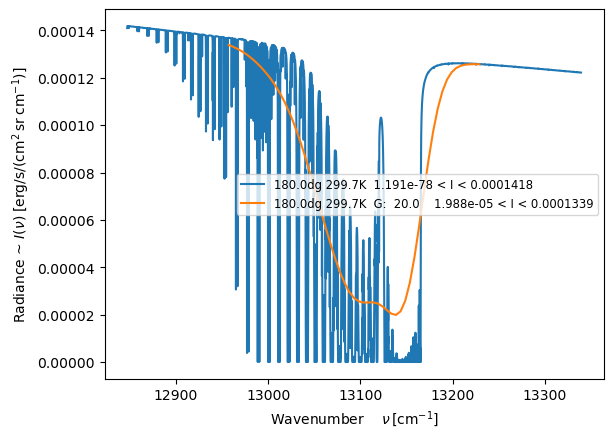

In [49]:
#Perform convolution of radiance calculation to match camera better
radBruce_G = radBruce.convolve(20.,'G')  #convolves the radiance with gaussian of 20 cm-1 HWHM
riPlot(radBruce)
riPlot(radBruce_G)

In [13]:
#Setup up dataframe for unit conversion and saving:
x_values = np.linspace(radBruce_G.x.lower, radBruce_G.x.upper, len(radBruce_G))

df = pd.DataFrame({'cm-1': x_values, 'ergs': radBruce_G})
df['nm'] = 1e7 / df['cm-1']
df['W'] = 1e4*df['ergs'] # erg -> joule 1e-7 cm->nm 1e7, cm2->m2 1e4


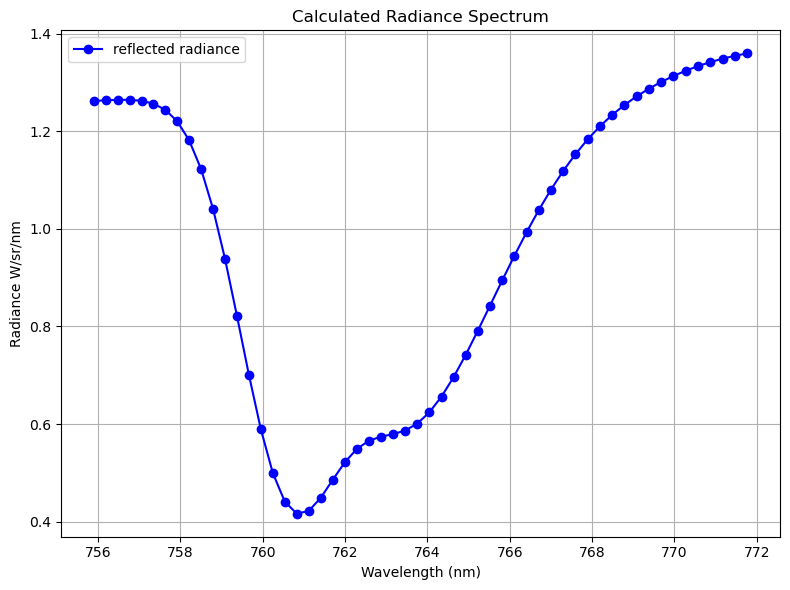

In [17]:
# Plot x vs y
plt.figure(figsize=(8, 6))  # Optional: adjust figure size
plt.plot(df['nm'], df['W'], marker='o', linestyle='-', color='b', label='reflected radiance')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Radiance W/sr/nm')
plt.title('Calculated Radiance Spectrum')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
band_avR = df[(df['nm'] >= 759) & (df['nm'] <= 766)]['W'].mean()
bkg_avR = df[(df['nm'] >= 745) & (df['nm'] <= 758)]['W'].mean()
ratio =band_avR/bkg_avR
print(ratio)

0.49779761161756225
